# Modelo de protones libres dentro de una célula.

Dentro de una célula hay protones libres cuya concentración está relacionada con el pH de la célula de la siguiente manera

$$
pH = -log[H+]
$$

Como el volumen de una célula es pequeño, la cantidad de protones libres es del orden de 100 o 1000. Esto no es muy grande, con lo cual se puede modelar cada protón individualmente. En este notebook se modelan estos protones, canales iónicos en la membrana de la célula y disociaciones aleatorias de partículas neutras a bases y protones libres. Con este modelo se cuenta el número de protones libres dentro de la célula para cada paso de tiempo y se grafica.

Primero se importan las librerías:

In [5]:
from pylab import *
%matplotlib inline
import random

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

Aquí se programa un integrador numérico con el metodo de Runge-Kutta de cuarto orden:

In [7]:
def rk4_a(ec,p_ini,x,args=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:] = sol[i,:] + (h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:] = sol[i,:] + (h/6.)*(k1+2*k2+2*k3+k4)

    return tiempos,sol

Sabemos que el cambio en la posición (dx) es igual a la velocidad, i.e. $dx = v_x$, y el cambio en la velocidad (dvx) es igual a la aceleración. La siguiente función toma como argumentos la posición y velocidad inicial (r_v) y regresa las derivadas de cada uno (dx,dy,dvx,dvy). Al integrar esto se puede obtener la posición y velocidad para cada paso de tiempo.

Adicionalmente se pueden añadir modelos de fricción, diferentes valores para la gravedad y diferentes valores para la masa de las partículas. 

In [8]:
def e_mov(r_v,t,fric=0,g=0,m=1):
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2] 
    dy = r_v[3]
    
    if fric==0:
        dvx,dvy = 0, -(g/m)
        
    else:
        dvx = -  fric([r_v[2],r_v[3]])[0] #nuestro modelo de fricción sólo depende de la velocidad 
        dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]

    
    return array([dx,dy,dvx,dvy])


Fricción lineal y cuadrática por si a caso

In [9]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y])

def fric_v2(v,gamma=0.1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y= gamma*norm_v*v[1]
    return array([f_x,f_y])

# Protones en un rectángulo con canales (1ra aproximación)

Aquí se programa el bote de los protones con las cuatro paredes. Se usa el método de bisección para encontrar la posición exacta del bote con la precisión deseada. También se programó que cuando los protones entren dentro de el área de influencia de un canal iónico se salgan de la célula y se queden estáticos afuera. 

In [10]:
def tiro1(p,N,fric,canal,rad_canal):

    trayectoria = zeros((N,len(p)))
    mi_dt = .1
    trayectoria[0,:] = array(p)
    n = 0
    for i in range(N-1):
        t,sol_dt = rk4_a(e_mov,trayectoria[i,:],[0,mi_dt],fric)
        
        ## pared inferior ##
        
        if sol_dt[-1,1] < 0:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[1]) > 1e-1:
                if (y_izq[1])*(y_med[1]) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            trayectoria[i+1,:] = y_izq    
       
        ## pared superior ##
        
        elif sol_dt[-1,1] > 5:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[1]-5) > 1e-1:
                if (y_izq[1]-5)*(y_med[1]-5) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            trayectoria[i+1,:] = y_izq    

        ## pared izquierda ##
        
        elif sol_dt[-1,0] < 0:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[0]) > 1e-1:
                if (y_izq[0])*(y_med[0]) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
            trayectoria[i+1,:] = y_izq    
       
        ## pared derecha ##
        
        elif sol_dt[-1,0] > 3:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[0]-3) > 1e-1:
                if (y_izq[0]-3)*(y_med[0]-3) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
            trayectoria[i+1,:] = y_izq
        
        
        
        
        
        ## aquí sale el protón cuando entra en el campo del canal ##
        
        
        else:
        
            for j in range(len(canal)):

                if ((sol_dt[-1,0] - canal[j][0])**2 + (sol_dt[-1,1] - canal[j][1])**2) < (rad_canal)**2:

                    ## hace que el protón se quede en un punto fijo fuera ##

                    for k in range(N-i-1):
                        trayectoria[k+i+1,:] = [canal[j][0]-1,canal[j][1],0,0]
                    n = n+1
                    return trayectoria,n,i
                    quit()

                else:
                    trayectoria[i+1,:] = sol_dt[-1,:]


    return trayectoria,n,i

Aquí se programa una función que usa la anterior, la grafica, cuenta los protones dentro de la célula y grafica éstos también. Como condición inicial pone protones en posiciones aleatorias dentro de la célula y con velocidades aleatorias dentro de cierto rango.

In [11]:
def celula1(protones,tiempo,canales_Izq,rad_canal,vel_media,pared,techo):
    
    x = linspace(-4,8,1)
    m = zeros(tiempo)
    m[0] = protones
    nn = zeros(tiempo)

    for l in range(protones):
        #p_ini = [1,2,-1,0]
        p_ini = [pared*rand(),techo*rand(),2*vel_media*(rand()-0.5),2*vel_media*(rand()-0.5)]
        trayectoria,n,i = tiro1(p_ini,tiempo,0,canales_Izq,rad_canal)
        nn[i] = nn[i] + n

        #plot(trayectoria[:,0],trayectoria[:,1],'--')
        plot(trayectoria[-1,0],trayectoria[-1,1],marker = 'o', color = 'blue', markersize = 3.5, markeredgewidth = 0.1)

    ## cuenta los protones dentro de la célula ##    

    for i2 in range(tiempo - 1):
        m[i2 + 1] = m[i2] - nn[i2]    

    plt.plot((0, 0), (0, techo), 'green')
    plt.plot((0, pared), (techo, techo), 'green')
    plt.plot((pared,pared),  (techo, 0), 'green')
    plt.plot((0,pared),  (0, 0), 'green')

    for j in range(len(canales_Izq)):
    
        y = linspace(-rad_canal,rad_canal,100)
        plot(sqrt(rad_canal**2 - y**2),y+canales_Izq[j][1],'red')
        plot(sqrt(rad_canal**2 - y**2),y+canales_Izq[j][1],'red')

    plt.ylim(-1,6)
    plt.xlim(-1,4)

    plt.axes().set_aspect('equal', 'datalim')
    grid(True)
    show()

    ejex = arange(tiempo)
    plot(ejex,m)

    #print trayectoria
    #print nn
    #print m

Vemos que el número de protones libres decae con el tiempo.

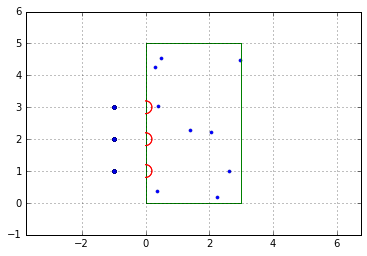

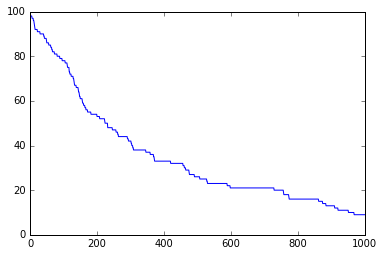

In [8]:
celula1(100,1000,[[0,1],[0,2],[0,3]],0.2,1,3,5)

# Bases y Protones (2da aproximación)

Esta primera función programa el bote con las cuatro paredes como la anterior, pero sin los canales iónicos.

In [2]:
def tiro2(p,N,fric,pared,techo):

    trayectoria = zeros((N,len(p)))
    mi_dt = .1
    trayectoria[0,:] = array(p)
    n = 0
    for i in range(N-1):
        
        
        ## Plan de la estructura ##
        
        ## if chocan entonces pos[i] = (0,-1,0,0)
        ## if pos[i] = (0,-1,0,0) and rand() > 0.9 
        
        
        t,sol_dt = rk4_a(e_mov,trayectoria[i,:],[0,mi_dt],fric)
        
        ## pared inferior ##
        
        if sol_dt[-1,1] < 0:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[1]) > 1e-1:
                if (y_izq[1])*(y_med[1]) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            trayectoria[i+1,:] = y_izq    
       
        ## pared superior ##
        
        elif sol_dt[-1,1] > techo:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[1]-techo) > 1e-1:
                if (y_izq[1]-techo)*(y_med[1]-techo) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            trayectoria[i+1,:] = y_izq    

        ## pared izquierda ##
        
        elif sol_dt[-1,0] < 0 and sol_dt[-1,0] > -0.4:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[0]) > 1e-1:
                if (y_izq[0])*(y_med[0]) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
            trayectoria[i+1,:] = y_izq    
       
        ## pared derecha ##
        
        elif sol_dt[-1,0] > pared:
            dt_busqueda = mi_dt/2
            y_izq = trayectoria[i,:]
            t,sol = rk4_a(e_mov,trayectoria[i,:],[0,dt_busqueda],fric)
            y_med = sol[-1,:]
            while abs(y_izq[0]-pared) > 1e-1:
                if (y_izq[0]-pared)*(y_med[0]-pared) < 0:
                    reinicio = y_izq
                else:
                    reinicio = y_med
                dt_busqueda = dt_busqueda/2
                t,sol = rk4_a(e_mov,reinicio,[0,dt_busqueda],fric)
                y_izq = reinicio
                y_med = sol[-1,:]
            y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
            trayectoria[i+1,:] = y_izq
        
        
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]

    return trayectoria[-1,:]

Aquí se programa la disociación aleatroria de las partículas neutras con una probabilidad dadda. También se hace el paso de integración y quita ambos base y protón si éstos chocan, i.e. si se encuentran más cerca entre si que cierto valor preestablecido. Por último, programa los canales iónicos en las paredes. 

El número de canales depende sólo de la densidad de canales deseada. Aquí se programa el radio de influencia de un canal como un medio círculo de radio igual al de una molécula de agua. Esto es una primera aproximación, acepto sugerencias. La densidad de canales aún queda un poco en duda. La probabilidad de disociación de las partículas neutras también queda por verse.

In [3]:
def prueba1(NumP,NumB,tiempo, Ptotales, Btotales, Interaccion, pared,techo,vel_media,Prob,canal,rad_canal):
    
    p_ini_P = zeros((Ptotales,4))
    p_ini_B = zeros((Btotales,4))
    trayectoria_P = zeros((Ptotales,tiempo,4))
    trayectoria_B = zeros((Btotales,tiempo,4))
    n = zeros(tiempo)
    
    ## Pone a todos afuera ##
    
    for l in range(Ptotales):
        p_ini_P[l,:] = [-0.5,0.4,0,0]
        
    for l in range(Btotales):
        p_ini_B[l,:] = [-0.5,0.2,0,0]
    
    ## Pone la condición inicial a los que sí están adentro##
    
    for l in range(NumP):
        p_ini_P[l,:] = [pared*rand(),techo*rand(),2*vel_media*(rand()-0.5),2*vel_media*(rand()-0.5)]

    for l in range(NumB):
        p_ini_B[l,:] = [pared*rand(),techo*rand(),2*vel_media*(rand()-0.5),2*vel_media*(rand()-0.5)]
        
    
    for i in range(Ptotales):
        for k in range(4):
            trayectoria_P[i,0,k] = p_ini_P[i,k]
        
    for i in range(Btotales):
        for k in range(4):
            trayectoria_B[i,0,k] = p_ini_B[i,k]
    
    
    ## Da los pasos de tiempo ##
    
    for i in range(tiempo-1):
        
        
        ## añade partículas aleatoriamente ##
        
        nn = 0
        
        for j in range(Ptotales):
            ## para que sólo haga esto con 10 partículas y no con todas... si son menos? ##
            
            if trayectoria_P[j,i,0] == -0.5 and rand()<Prob and nn<1:
                
                nnn = 0
                
                ## posición en la que aparecen ##
                x = (pared - 4*Interaccion)*rand() + 2*Interaccion
                y = (techo - 4*Interaccion)*rand() + 2*Interaccion
                
                ## velocidad a la que salen lanzados ##
                velx = 2*vel_media*(rand()-0.5) 
                vely = 2*vel_media*(rand()-0.5)
                
                
                ## añade protón ##
                trayectoria_P[j,i,:] = [x,y,velx,vely]
                
                
                ## añade base ##
                for k in range(Btotales):
                    if trayectoria_B[k,i,0] == -0.5 and nnn<1:
                        trayectoria_B[k,i,:] = [x,y,-velx,-vely]
                        nnn = nnn + 1
                ## cuenta ##
                nn = nn + 1
                n[i] = n[i] - 1
        
        
        ## integrador numérico ##
        
        for j in range(Ptotales):
            if trayectoria_P[j,i,0] != -0.5:
                trayectoria_P[j,i+1,:] = tiro2(trayectoria_P[j][i],2,0,pared,techo)
            else:
                trayectoria_P[j,i+1,:] = [-0.5,0.4,0,0]
        
        for j in range(Btotales):
            if trayectoria_B[j,i,0] != -0.5:
                trayectoria_B[j,i+1,:] = tiro2(trayectoria_B[j][i],2,0,pared,techo)
            else:
                trayectoria_B[j,i+1,:] = [-0.5,0.2,0,0]

        
        
        ## Quita las partículas si chocan ##
        
        for j in range(Ptotales):
            for k in range(Btotales):
                if ((trayectoria_P[j,i+1,0] - trayectoria_B[k,i+1,0])**2 + 
                    (trayectoria_P[j,i+1,1] - trayectoria_B[k,i+1,1])**2 < Interaccion 
                    and trayectoria_P[j,i+1,0] != -0.5):
                    trayectoria_P[j,i+1,:] = [-0.5,0.4,0,0]
                    trayectoria_B[k,i+1,:] = [-0.5,0.2,0,0]
                    n[i] = n[i] + 1
        
        
        ## aquí sale el protón cuando entra en el campo del canal ##
        for j in range(Ptotales):
            for c in range(len(canal)):

                if ((trayectoria_P[j,i+1,0] - canal[c][0])**2 + (trayectoria_P[j,i+1,1] - canal[c][1])**2) < (rad_canal)**2:

                    ## hace que el protón se quede en un punto fijo fuera ##
                    trayectoria_P[j,i+1,:] = [-0.5,0.4,0,0]
                    n[i] = n[i] + 1
        
    
    ## Grafica ##
    
    #for k in range(tiempo):
#    for i in range(Ptotales):
#        plot(trayectoria_P[i,k,0],trayectoria_P[i,k,1],marker='o', color = 'red', markersize = 3.5)
#        plot(trayectoria_P[i,:,0],trayectoria_P[i,:,1], '--')

#    for i in range(Btotales):
#        plot(trayectoria_B[i,k,0],trayectoria_B[i,k,1],marker='o', color = 'blue', markersize = 5)
#        plot(trayectoria_B[i,:,0],trayectoria_B[i,:,1], '--')
#
#    plt.plot((0, 0), (0, techo), 'green')
#    plt.plot((0, pared), (techo, techo), 'green')
#    plt.plot((pared,pared),  (techo, 0), 'green')
#    plt.plot((0,pared),  (0, 0), 'green')
#
#    plt.ylim(-1,6)
#    plt.xlim(-1,4)

#    plt.axes().set_aspect('equal', 'datalim')
#    grid(True)
#    show()
    return trayectoria_P,trayectoria_B,n

    

Aquí se establecen todas las constantes importantes del modelo incluyendo tiempo que va a correr la integración, número de protones y de bases, tamaño de la célula (pared y techo), probabilidad de disociación de las partículas neutras, radio del canal y densidad de canales por unidad de distancia. Cada unidad de distancia es $1 \mu m$.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


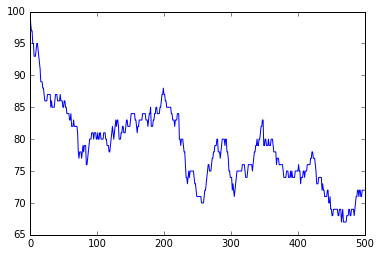

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


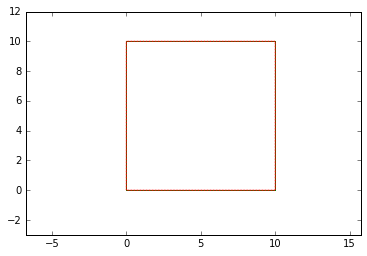

In [12]:
NumP = 100 
NumB = 50
tiempo = 500
Btotales = 200
Ptotales = 200
Interaccion = 0.01
pared = 10
techo = 10
vel = 1
Prob = 0.006
#canal = [[0,1],[0,2],[0,3]]
rad_canal = 0.003


## crea el vector de canales sólo dependiente de la densidad ## 
densidad_c = 10
canales_totales = 2*np.floor(pared*densidad_c) + 2*np.floor(techo*densidad_c)
canal = zeros((canales_totales,2))
for i in arange(0,np.floor(densidad_c*pared)):
    canal[i] = [0,(i+0.5)/densidad_c]
for i in arange(0,np.floor(densidad_c*pared)):
    canal[np.floor(densidad_c*pared) + i] = [pared,(i+0.5)/densidad_c]
for i in arange(0,np.floor(densidad_c*techo)):
    canal[2*np.floor(densidad_c*techo) + i] = [(i+0.5)/densidad_c,0]
for i in arange(0,np.floor(densidad_c*techo)):
    canal[2*np.floor(densidad_c*techo) + np.floor(densidad_c*techo)+ i] = [(i+0.5)/densidad_c,techo]

m = zeros(tiempo)
m[0] = NumP

trayectoria_P, trayectoria_B, n = prueba1(NumP,NumB,tiempo,Btotales,Ptotales,Interaccion,pared,techo,vel,Prob,canal,rad_canal)

## hace el vector que cuenta ##
for i2 in range(tiempo - 1):
    m[i2 + 1] = m[i2] - n[i2] 
    
ejex = arange(tiempo)
plot(ejex,m)
show()

fig, ax = plt.subplots()

particles1, = ax.plot([], [], 'ro')
particles2, = ax.plot([], [], 'bo')

## dibuja la caja ##
ax.plot((0, 0), (0, techo), 'green')
ax.plot((0, pared), (techo, techo), 'green')
ax.plot((pared,pared),  (techo, 0), 'green')
ax.plot((0,pared),  (0, 0), 'green')
ax.axis('equal')
ax.set_xlim(( -3, 12))
ax.set_ylim((-3, 12))


## dibuja los canales ##
    
y = linspace(-rad_canal,rad_canal,100)
    
for j in arange(0,np.floor(densidad_c*pared)):
    ax.plot(sqrt(rad_canal**2 - y**2)+canal[j,0],y+canal[j][1],'red')
for j in arange(np.floor(densidad_c*pared),2*np.floor(densidad_c*pared)):
    ax.plot(-sqrt(rad_canal**2 - y**2)+canal[j,0],y+canal[j][1],'red')
for j in arange(2*np.floor(densidad_c*techo),2*np.floor(densidad_c*pared) + np.floor(densidad_c*techo)):
    ax.plot(y+canal[j][0],sqrt(rad_canal**2 - y**2)+canal[j,1],'red')
for j in arange(2*np.floor(densidad_c*pared) + np.floor(densidad_c*techo), 2*np.floor(densidad_c*pared) + 2*np.floor(densidad_c*techo)):
    ax.plot(y+canal[j][0],-sqrt(rad_canal**2 - y**2)+canal[j,1],'red')

    
    

## hace el video ##    
def init():
    particles1.set_data([], [])
    particles2.set_data([], [])
    return (particles1,particles2)


def animate(i):
    x = trayectoria_P[:,i,0]
    y = trayectoria_P[:,i,1]
    
    z = trayectoria_B[:,i,0]
    w = trayectoria_B[:,i,1]
    
    particles1.set_data(x,y)
    particles2.set_data(z,w)

    return (particles1,particles2)

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=tiempo, interval=100, blit=True)

Finalmente vemos un video del resultado de la programación y una gráfica de la cantidad de protones libres contra el tiempo. Parece ser que se estabiliza después de un cierto tiempo.

In [13]:
## imprime el video ##
HTML(anim.to_html5_video())

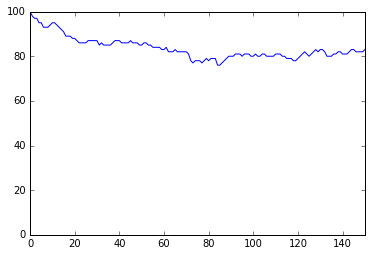

In [14]:
ejex = arange(tiempo)
plot(ejex,m)
xlim(0,150)
ylim(0,100)
show()

In [29]:
def celula2(protones,bases,tiempo,vel_media,pared,techo):
    
    x = linspace(-4,8,1)
    m = zeros(tiempo)
    m[0] = protones
    nn = zeros(tiempo)

    for l in range(protones):
        #p_ini = [1,2,-1,0]
        p_ini = [pared*rand(),techo*rand(),2*vel_media*(rand()-0.5),2*vel_media*(rand()-0.5)]
        trayectoria,n,i = tiro2(p_ini,tiempo,0)
        nn[i] = nn[i] + n

        #plot(trayectoria[:,0],trayectoria[:,1],'--')
        plot(trayectoria[-1,0],trayectoria[-1,1],marker = 'o', color = 'red', markersize = 3.5, markeredgewidth = 0.1)

        
    for l in range(bases):
        #p_ini = [1,2,-1,0]
        p_ini = [pared*rand(),techo*rand(),2*vel_media*(rand()-0.5),2*vel_media*(rand()-0.5)]
        trayectoria,n,i = tiro2(p_ini,tiempo,0)
        nn[i] = nn[i] + n

        #plot(trayectoria[:,0],trayectoria[:,1],'--')
        plot(trayectoria[-1,0],trayectoria[-1,1],marker = 'o', color = 'blue', markersize = 5, markeredgewidth = 0.1)

        
    ## cuenta los protones dentro de la célula ##    

    for i2 in range(tiempo - 1):
        m[i2 + 1] = m[i2] - nn[i2]    

    plt.plot((0, 0), (0, techo), 'green')
    plt.plot((0, pared), (techo, techo), 'green')
    plt.plot((pared,pared),  (techo, 0), 'green')
    plt.plot((0,pared),  (0, 0), 'green')

    plt.ylim(-1,6)
    plt.xlim(-1,4)

    plt.axes().set_aspect('equal', 'datalim')
    grid(True)
    show()

    ejex = arange(tiempo)
    plot(ejex,m)


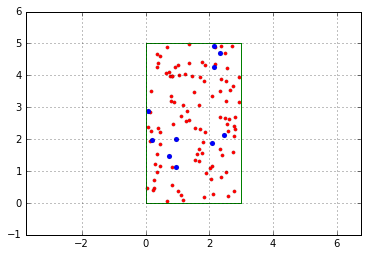

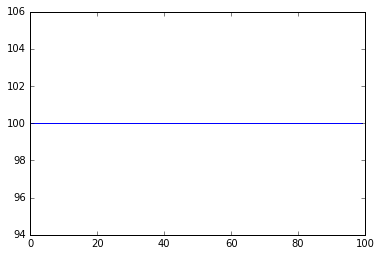

In [69]:
celula2(100,10,100,1,3,5)

In [57]:
rand()

0.43296289523215126

In [68]:
prueba = [[1,2],[3,4],[5,6]]
prueba[0][1]
print len(prueba)

3


In [140]:
a = xrange(5)
print a

xrange(5)


In [148]:
linspace(-0.5,0.5,5)

array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ])

In [177]:
zeros((2,1))

array([[ 0.],
       [ 0.]])

In [ ]:
        #for j in range(len(canal)):
        elif ((sol_dt[-1,0] - canal[1][0])**2 + (sol_dt[-1,1] - canal[1][1])**2) < 0.1:
            
            ## hace que el protón se quede en un punto fijo fuera ##
            
            for k in range(N-i-1):
                trayectoria[k+i+1,:] = [canal[1][0]-0.5,canal[1][1],0,0]
            n = n+1
            return trayectoria,n,i
            quit()

In [85]:
B=zeros((3,2,4))
B[:,0,:] = [[1,2,3,4],[5,6,7,8],[9,1,2,3]]
print B
print B[1][0]

[[[ 1.  2.  3.  4.]
  [ 0.  0.  0.  0.]]

 [[ 5.  6.  7.  8.]
  [ 0.  0.  0.  0.]]

 [[ 9.  1.  2.  3.]
  [ 0.  0.  0.  0.]]]
[ 5.  6.  7.  8.]


In [20]:
a = 3
if a != 5:
    print 3

3


In [78]:
a = array(3)
print a

TypeError: data type not understood

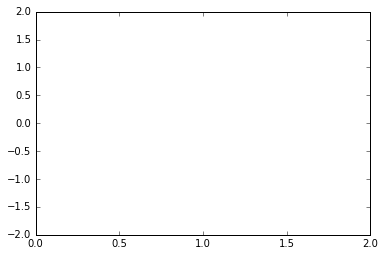

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML



# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)



In [40]:


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)



In [41]:


# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)



In [42]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)


In [43]:
HTML(anim.to_html5_video())

In [48]:
np.linspace(0, 2, 10)

array([ 0.        ,  0.22222222,  0.44444444,  0.66666667,  0.88888889,
        1.11111111,  1.33333333,  1.55555556,  1.77777778,  2.        ])

In [49]:
zeros(3)

array([ 0.,  0.,  0.])

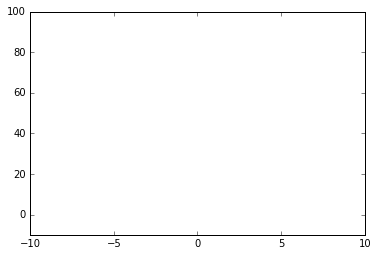

In [75]:
fig, ax = plt.subplots()

ax.set_xlim(( -10, 10))
ax.set_ylim((-10, 100))

line, = ax.plot([], [], 'bo', ms = 6)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(-5, 5, 10)
    y = x + i
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=100, interval=20, blit=True)

In [76]:
HTML(anim.to_html5_video())

In [53]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

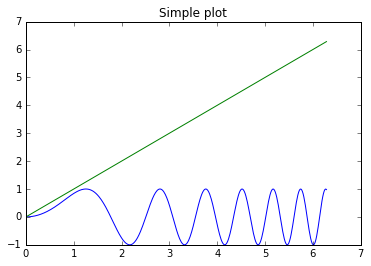

In [68]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x,x)
ax.set_title('Simple plot')

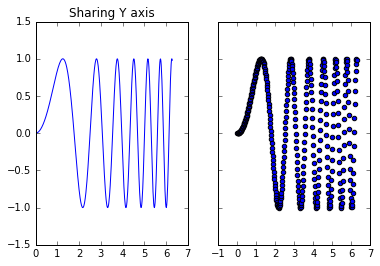

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey='all')
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

In [96]:
rand()

0.17625497036586846

In [94]:
zeros((3,2))

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [23]:
arange(1,np.floor(3.5))

array([ 1.,  2.])

In [6]:
range(3)

[0, 1, 2]

In [1]:
10**(-7)*(6.022*(1e23))/(1000000000000)

60219.99999999999